# Calculation of Al Implantation in SiC

In [1]:
%matplotlib inline

import os
from collections import Counter
from itertools import count
from random import randint
from pathlib import Path
import math

# Only needed to embed the images in notebook so they
# show up in gitlab repo
from IPython.display import Image

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import gaussian_kde
# import seaborn

# For parallelization
import concurrent.futures

from srim import TRIM, Target, Layer, Ion, Element

# directory to srim executable
SRIM_EXECUTABLE_DIRECTORY = os.path.abspath('/home/filipov/Software/pysrim/srim_install')
# directory to store srim output (does not have to exist)
DATA_DIRECTORY = os.path.abspath('/home/filipov/Research/BCA/output')
# directory to store images from processing srim output (does not have to exist)
IMAGE_DIRECTORY = os.path.abspath('/home/filipov/Research/BCA/images')

os.makedirs(DATA_DIRECTORY, exist_ok=True)
os.makedirs(IMAGE_DIRECTORY, exist_ok=True)

The directory structure that SRIM calculations will be stored in.

```
DATA_DIRECTORY/
 - Al/
    - 0/
    - 1/
    - 2/
  ...
```

# Al in SiC  

This script defines the parameters for ion irradiation simulations of aluminum (Al) ions in a silicon carbide (SiC) target. The goal is to compute ion interactions and generate plots of the ion trajectories and damage distribution.

## Simulation Parameters

### Ions
- Incident ion: Aluminum (Al)
- Ion energy: 150 keV

### Target Material
- Silicon carbide (SiC)
- Density: 3.21 g/cm³  
- Sublattice composition:
  - Silicon (Si):  
    - Stoichiometry: 0.5 (SiC is a 1:1 compound of Si and C)  
    - Threshold displacement energy (E<sub>d</sub>): 35 eV
      - Energy required to displace a silicon atom from its lattice site
    - Lattice binding energy: 4.8 eV
      - This represents the energy required to remove an atom from its position within the crystal lattice of a material.
      - It accounts for the forces holding the atom in place within the bulk of the solid.
      - A higher lattice binding energy means that atoms are more strongly bound within the crystal, making displacement more difficult.
    - Surface binding energy: 3.0 eV
      - This is the energy needed to remove an atom from the surface of the material.
      - Atoms at the surface experience fewer bonding interactions compared to those inside the lattice, meaning surface binding energies are typically lower than lattice binding energies.
      - This value is crucial in sputtering calculations, where incident ions may eject surface atoms.
  - Carbon (C):  
    - Stoichiometry: 0.5  
    - Threshold displacement energy (E<sub>d</sub>): 20 eV  
    - Lattice binding energy: 7.1 eV  
    - Surface binding energy: 3.0 eV  

### Simulation Depth and Output
- The target material is modeled as a 10,000 nm thick SiC layer.  
- However, only the first 1000 nm will be plotted in 2D projections along different planes:
  - XY plane (depth vs lateral displacement)
  - XZ plane (depth vs horizontal displacement)
  - YZ plane (depth vs vertical displacement)  

### Ion Simulation Parameters
- IONS_PER_STEP: 100
  - Defines how many ions are simulated in each calculation step to allow for fragmentation and efficient computation.
  - Step size should not exceed 1000 ions if storing collision data (`COLLISON.txt`).
- NUM_IONS: 3000
  - Total number of ions simulated for the study.

### TRIM (Transport of Ions in Matter) Settings
- Calculation Mode: 2 (Full cascade mode, where both primary and secondary recoils are tracked)  
- Collision Mode: 2 (Simulates all types of ion collisions)  
- Ion Incidence Angle: 4° (Average angle of incident ions, potentially simulating a slight beam divergence)  

In [2]:
# Define calculations in code
ions = [
    {'identifier': 'Al', 'energy': 150.0e3}, # eV
]

layer = Layer({
    'Si': {
        'stoich': 0.5,
        'E_d': 35.0, # Displacement Energy
        'lattice': 4.8,
        'surface': 3.0
    },
    'C': {
        'stoich': 0.5,
        'E_d': 20.0, # Displacement Energy
        'lattice': 7.1,
        'surface': 3.0
    }
}, density=3.21, width=10000.0)
target = Target([layer])

# number of ions to use in each SRIM calculation
# allows for fragmentation of calcluation
# step size should never be larger than 1,000
# if you are storing COLLISON.txt
IONS_PER_STEP = 100
# number of ions to simulate for each ion
NUM_IONS = 3000

# See TRIMSettings and TRIM for full options
# you can do any setting that you could do in TRIM
TRIM_SETTINGS = {
    'calculation': 2, # full cascade
    'collisions': 2,
    'angle_ions': 4
}

In [3]:
import os
import multiprocessing
import shutil
from pathlib import Path
from itertools import count

def fragment(step, total):
    """Generator to yield ion fragments for processing."""
    remaining = total
    while remaining > 0:
        if step > remaining:
            yield remaining
            break
        else:
            remaining -= step
            yield step

def find_folder(directory):
    """Finds a unique folder path for saving results."""
    for i in count():
        path = Path(directory) / str(i)
        if not path.is_dir():
            os.makedirs(path, exist_ok=True)  # Create folder immediately
            return str(path.absolute())

def run_single_fragment(i, num_ions, ion, target, path, trim_settings):
    """Runs TRIM for a single ion fragment in a separate process, passing a unique process ID."""
    process_id = os.getpid()  # Generate unique ID based on process ID
    print(f"Process {process_id} running fragment {i}: {num_ions} ions for {ion.symbol}")

    trim_settings = trim_settings or {'calculation': 2}

    # Run TRIM, passing the SRIM executable directory and unique process ID
    trim = TRIM(target, ion, number_ions=num_ions, **trim_settings)
    results = trim.run(SRIM_EXECUTABLE_DIRECTORY, process_id)  # Pass both

    # Find a unique save directory and copy results
    save_directory = find_folder(path)
    os.makedirs(save_directory, exist_ok=True)

    TRIM.copy_output_files(results, save_directory)
    print(f"Fragment {i} saved to: {save_directory}")

def run_fragmented_calculation(ion, target, number_ions, path, trim_settings, step):
    """Runs TRIM calculations in parallel for each fragment, ensuring unique execution paths."""
    pool_args = [(i, num_ions, ion, target, path, trim_settings) 
                 for i, num_ions in enumerate(fragment(step, number_ions))]

    num_workers = min(len(pool_args), os.cpu_count())  # Limit to available CPU cores
    with multiprocessing.Pool(processes=num_workers) as pool:
        pool.starmap(run_single_fragment, pool_args)  # Run fragments in parallel

# Running TRIM in fragments

TRIM has a tendancy to crash so the above wrapper functions run a TRIM calcualtion in `steps` of size 1,000 ions - 10,000 total.

In addition it runs these many calculations in batch and write the output folders in this structure
```
 - Al/
    - 0/
    - 1/
    - 2/
...```

In [4]:
# Run SRIM calcluations for each ion
for ion in ions:
    symbol_path = os.path.join(DATA_DIRECTORY, ion['identifier'])
    run_fragmented_calculation(Ion(**ion), target, NUM_IONS, symbol_path, TRIM_SETTINGS, step=IONS_PER_STEP)

Process 66244 running fragment 3: 100 ions for AlProcess 66241 running fragment 0: 100 ions for AlProcess 66243 running fragment 2: 100 ions for AlProcess 66247 running fragment 6: 100 ions for AlProcess 66245 running fragment 4: 100 ions for AlProcess 66246 running fragment 5: 100 ions for AlProcess 66242 running fragment 1: 100 ions for AlProcess 66249 running fragment 8: 100 ions for AlProcess 66248 running fragment 7: 100 ions for Al



Process 66250 running fragment 9: 100 ions for Al

Process 66251 running fragment 10: 100 ions for Al




Process 66252 running fragment 11: 100 ions for Al
Deleted source directory: /tmp/trim_66245
Fragment 4 saved to: /home/filipov/Research/BCA/output/Al/0
Process 66245 running fragment 12: 100 ions for Al
Deleted source directory: /tmp/trim_66249
Fragment 8 saved to: /home/filipov/Research/BCA/output/Al/1
Process 66249 running fragment 13: 100 ions for Al
Deleted source directory: /tmp/trim_66250
Fragment 9 saved to: /home/filipov/Research/BCA/ou

# Analysis

We are going to plot the collisions from ions and recoil atoms. The COLLISON.txt file can get huge.

 - Read Collisions.txt
 - Plot heatmap of yz plane
 - Radial distribution of yz plane about center (0, 0)

In [5]:
# Helper functions
def parse_directory(dir):
    """ Parse directory with expected structure <dir>/<ion_symbol>/<int>/COLLISON.txt
    
    This functions will collect the position <x, y, z> of every ion and recoil collision.
    
    It will write to a numpy array the parsing. This file will be about 10% of the original
    """
    if not os.path.exists(os.path.join(dir, 'collision.dat.npy')):
        positions = []
        with open(os.path.join(dir, 'COLLISON.txt'), 'rb') as f:
            for line in f.readlines():
                line = line.decode('latin-1')
                if line.endswith('Start of New Cascade  ³\r\n'):
                    tokens = line.split(chr(179))[1:-1]
                    positions.append([float(tokens[2]), float(tokens[3]), float(tokens[4])])
                elif line.startswith('Û 0'):
                    tokens = line.split()[1:-1]
                    positions.append([float(tokens[3]), float(tokens[4]), float(tokens[5])])
        np.save(os.path.join(dir, 'collision.dat'), np.array(positions))

def plot_heatmap(ax, data, cols, limits, norm, bins=(1000, 200)):
    """ Plot a heatmap
    
    Parameters
    ----------
    ax : maptlotlib.axes
        axis to plot heatmap on
    data : np.ndarray
        numpy array that was constructed from 'parse_directory' it is [Nx3] in dimmension.
    cols : tuple
        tuple or list length 2. example (0, 2) x, z axis
    limits : tuple
        tuple or list (2x2) [[col[0] min, col[0] max], [col[0] min, col[0] max]]
    norm : mpl.colors
        colorbar scale to use
    """
    c1, c2 = cols
    (c1min, c1max), (c2min, c2max) = limits
    region_data = data[(data[:, c1] < c1max) & (data[:, c1] > c1min) & (data[:, c2] < c2max) & (data[:, c2] > c2min)]
    heatmap, xedges, yedges = np.histogram2d(region_data[:, c1], region_data[:, c2], range=limits, bins=bins)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    heatmap[heatmap == 0.0] = np.nan
    # colormap = mpl.cm.get_cmap('viridis')
    colormap = mpl.colormaps['viridis']
    return ax.imshow(heatmap.T, origin='lower', extent=extent, cmap=colormap, norm=norm)
    
def plot_radial_distribution_hist(ax, data, maximum, label):
    """ plot radial distribution of data
    
    Parameters
    ----------
    ax : maptlotlib.axes
        axis to plot heatmap on
    data : np.ndarray
        numpy array that was constructed from 'parse_directory' it is [Nx3] in dimmension.
    maximum : float
        maximum distance to plot radial distribution
    label : str
        label to give for plot
    """
    density, edges = np.histogram(data, bins=100, density=False, range=(1e-8, maximum))
    x = np.linspace(1e-1, maximum, len(density))
    density = [d / (2 * math.pi * r)  for r, d in zip(x, density)]
    # return ax.plot(x, density, label=label)
    return ax.semilogy(x, density, label=label)
    
def plot_radial_distribution_kde(ax, data, maximum, label):
    """ Same as plot radial distribution of data except uses kde for smoothing"""
    x = np.linspace(0, maximum, 100)
    kde = gaussian_kde(np.concatenate((-data, data)))
    return ax.plot(x, kde.pdf(x), label=label)
    
sort_by_mass = lambda e1: Element(e1).mass

Read all SRIM Calculations and parse COLLISON.txt to produce numpy arrary this will traverse directory structure and create numpy data arrays in each folder

In [6]:
for dir in os.listdir(DATA_DIRECTORY):
    calculation_data = []
    total_ions = 0
    abs_dir_path = os.path.join(DATA_DIRECTORY, dir)
    if os.path.isdir(abs_dir_path):
        for calculation in os.listdir(abs_dir_path):
            if set(calculation) < set('0123456789') and os.path.isdir(os.path.join(abs_dir_path, calculation)): # check that dir only contains numbers
                parse_directory(os.path.join(abs_dir_path, calculation))
                print('parsed', os.path.join(abs_dir_path, calculation))

parsed /home/filipov/Research/BCA/output/Al/22
parsed /home/filipov/Research/BCA/output/Al/11
parsed /home/filipov/Research/BCA/output/Al/26
parsed /home/filipov/Research/BCA/output/Al/23
parsed /home/filipov/Research/BCA/output/Al/5
parsed /home/filipov/Research/BCA/output/Al/12
parsed /home/filipov/Research/BCA/output/Al/29
parsed /home/filipov/Research/BCA/output/Al/14
parsed /home/filipov/Research/BCA/output/Al/15
parsed /home/filipov/Research/BCA/output/Al/8
parsed /home/filipov/Research/BCA/output/Al/25
parsed /home/filipov/Research/BCA/output/Al/6
parsed /home/filipov/Research/BCA/output/Al/18
parsed /home/filipov/Research/BCA/output/Al/13
parsed /home/filipov/Research/BCA/output/Al/24
parsed /home/filipov/Research/BCA/output/Al/16
parsed /home/filipov/Research/BCA/output/Al/9
parsed /home/filipov/Research/BCA/output/Al/3
parsed /home/filipov/Research/BCA/output/Al/2
parsed /home/filipov/Research/BCA/output/Al/19
parsed /home/filipov/Research/BCA/output/Al/7
parsed /home/filipov

Combine all numpy array read from COLLISON.txt. This will take ALOT of RAM if NUM_IONS > 10,000 (4-6 Gb for me)

In [7]:
data = {}
for dir in os.listdir(DATA_DIRECTORY):
    collisions = []
    total_ions = 0
    if os.path.isdir(os.path.join(DATA_DIRECTORY, dir)):
        for calculation in os.listdir(os.path.join(DATA_DIRECTORY, dir)):
            with open(os.path.join(DATA_DIRECTORY, dir, calculation, 'TRIM.IN')) as f:
                num_ions = int(f.read().split('\n')[2].split()[-3])
            total_ions += num_ions
            collisions.append(np.load(os.path.join(DATA_DIRECTORY, dir, calculation, 'collision.dat.npy')))
        data[dir] = {'total_ions': total_ions, 'collisions': np.concatenate(collisions) / 10}

Print summary information about calculations and collisions

In [8]:
# print summary information
for ion in sorted(data, key=sort_by_mass):
    data_str = (
        "Symbol: {:2}\tNum Ions: {:7d}\tCollisions: {:7d}\n"
        "|\tMedian (x, y, z) [nm]: [{:.3f}\t{:.3f}\t{:.3f}]\n"
        "|\tMean   (x, y, z) [nm]: [{:.3f}\t{:.3f}\t{:.3f}]\n"
    )
    print(data_str.format(ion, data[ion]['total_ions'], len(data[ion]['collisions']), 
                          *np.median(data[ion]['collisions'], axis=0),
                          *np.mean(data[ion]['collisions'], axis=0)))

Symbol: Al	Num Ions:    3000	Collisions: 3605851
|	Median (x, y, z) [nm]: [116.300	5.701	0.045]
|	Mean   (x, y, z) [nm]: [115.525	9.164	0.172]



In [9]:
# Using Log color scale
# Collect all collision values across all ions
all_collisions = [data[ion]['collisions'] for ion in data]
all_values = np.concatenate(all_collisions)
# Determine min/max dynamically for both scales
# Assuming the second dimension is also meaningful and should be adapted
vertical_dim_values = np.array([point[0] for collisions in all_collisions for point in collisions])
min_vert, max_vert = np.min(vertical_dim_values), np.max(vertical_dim_values)
radial_dim_values = np.array([point[1] for collisions in all_collisions for point in collisions])
min_radial, max_radial = np.min(radial_dim_values), np.max(radial_dim_values)
print(min_vert, max_vert, min_radial, max_radial)

1e-05 321.5 -185.5 186.4


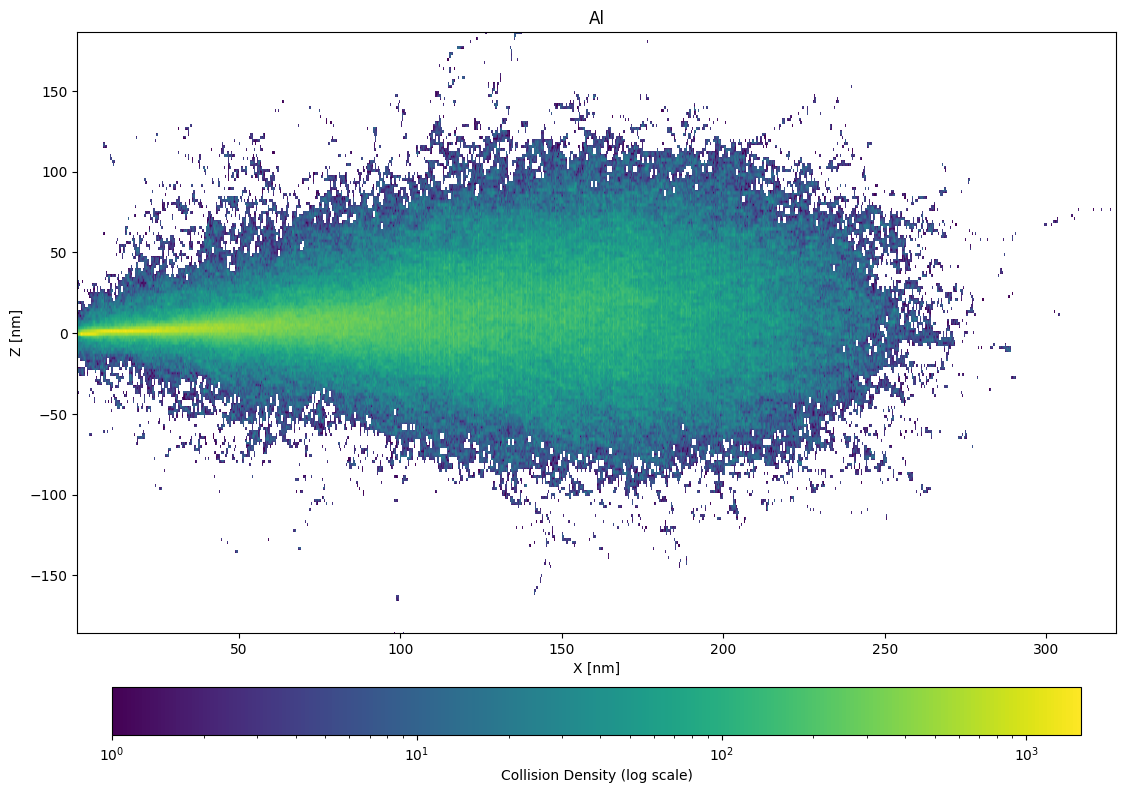

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

# Set dynamically calculated limits
limits = [[min_vert, max_vert], [min_radial, max_radial]]
bins = (1000, 200)

# Ensure ions is iterable and get the number of subplots needed
num_ions = len(ions)

# Handle case where there is only one ion
if num_ions == 1:
    fig, ax = plt.subplots(1, 1, figsize=(25, 10))  # Reduce height for single ion
    axes = [ax]  
else:
    fig, axes = plt.subplots(num_ions, 1, figsize=(25, 4 * num_ions))  # Increase height dynamically
    plt.subplots_adjust(hspace=0.2)  # Add more vertical space

for ax, ion in zip(axes, sorted(data, key=sort_by_mass)):
    norm = mpl.colors.LogNorm()
    im = plot_heatmap(ax, data[ion]['collisions'], (0, 1), limits, norm, bins=bins)
    ax.set_title(ion)
    ax.set_aspect(1/(2 * num_ions))  # Keep heatmap from getting too thin
    ax.set_ylabel('Z [nm]')

# Ensure only the last subplot has an X-axis label
axes[-1].set_xlabel('X [nm]')

# Add a horizontal colorbar at the bottom, with padding
cbar = fig.colorbar(im, ax=axes[:num_ions], location="bottom", shrink=0.5, pad=0.07)
cbar.set_label("Collision Density (log scale)")

# Save figure
fig.savefig(os.path.join(IMAGE_DIRECTORY, 'sic-length-heatmap-log.png'), transparent=False, dpi=300)

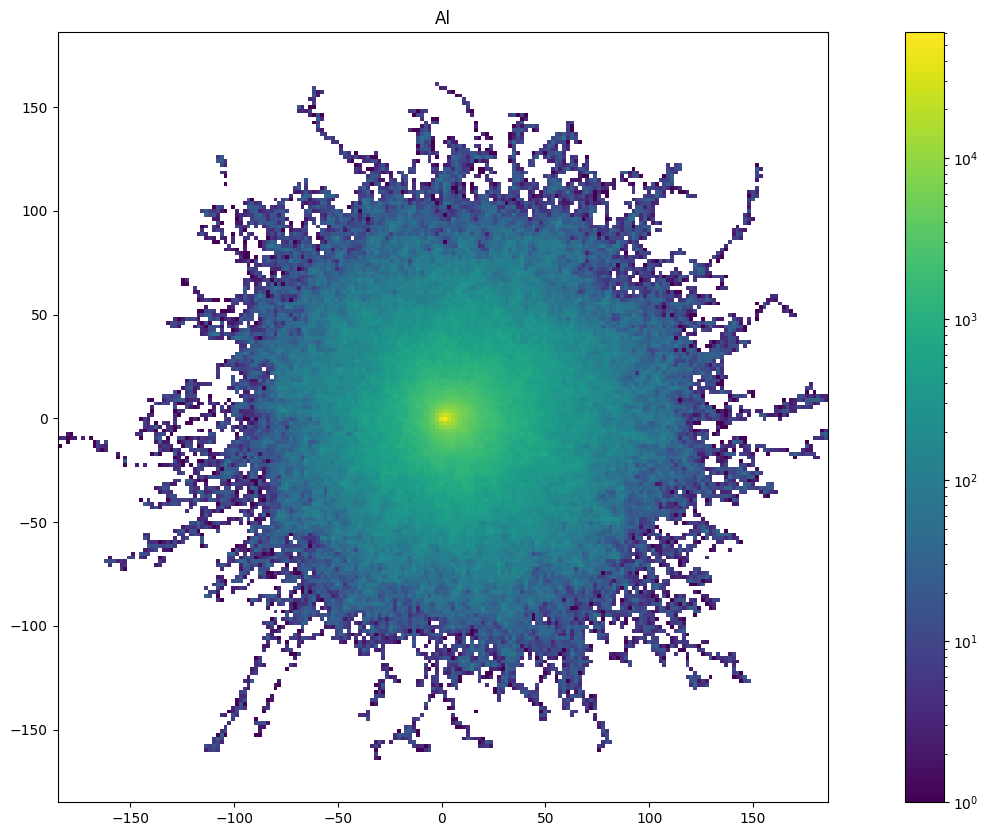

In [11]:
# Using Log color scale
limits = [[int(min_radial), int(max_radial)], [int(min_radial), int(max_radial)]]
bins = (200, 200)

# Determine optimal grid size
num_cols = min(3, num_ions)  # Up to 3 columns for better layout
num_rows = int(np.ceil(num_ions / num_cols))  # Adjust rows dynamically

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))
axes = np.array(axes).reshape(-1)  # Flatten in case of 1D array

for ax, ion in zip(axes, sorted(data, key=sort_by_mass)):
    norm = mpl.colors.LogNorm()
    im = plot_heatmap(ax, data[ion]['collisions'], (1, 2), limits, norm, bins=bins)
    ax.set_title(ion)

# Remove extra empty subplots
for ax in axes[num_ions:]:
    fig.delaxes(ax)

# Add a single colorbar for all subplots
fig.colorbar(im, ax=axes[:num_ions], location="right")

fig.savefig(os.path.join(IMAGE_DIRECTORY, 'sic-radial-heatmap-log.png'), transparent=False, dpi=300)

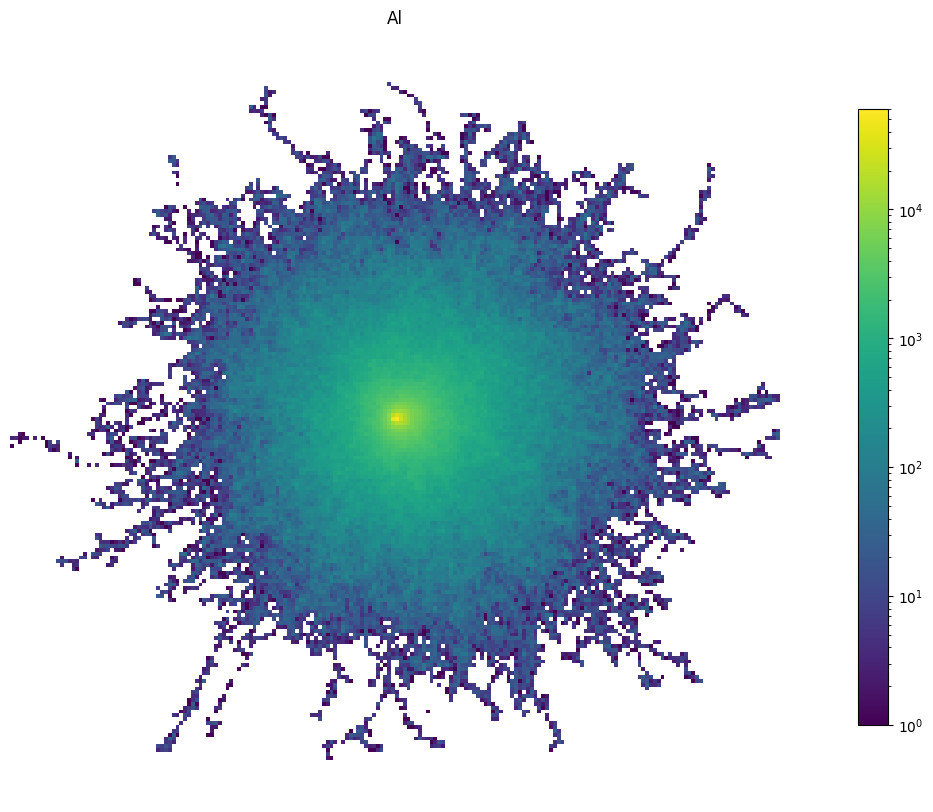

In [12]:
# Using Log color scale
limits = [[int(min_radial), int(max_radial)], [int(min_radial), int(max_radial)]]
bins = (200, 200)

# Determine optimal grid size
num_cols = min(3, num_ions)  # Up to 3 columns for better layout
num_rows = int(np.ceil(num_ions / num_cols))  # Adjust rows dynamically

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))
axes = np.array(axes).reshape(-1)  # Flatten in case of 1D array

for ax, ion in zip(axes, sorted(data, key=sort_by_mass)):
    norm = mpl.colors.LogNorm()
    im = plot_heatmap(ax, data[ion]['collisions'], (1, 2), limits, norm, bins=bins)
    ax.set_title(ion)
    ax.axis('off')

# Remove extra empty subplots
for ax in axes[num_ions:]:
    fig.delaxes(ax)

# Add a single colorbar for all subplots
fig.colorbar(im, ax=axes[:num_ions], location="right", shrink=0.8)

# Save the figure
fig.savefig(os.path.join(IMAGE_DIRECTORY, 'sic-radial-heatmap-log-nolabel.png'), transparent=False, dpi=300)

0 Al


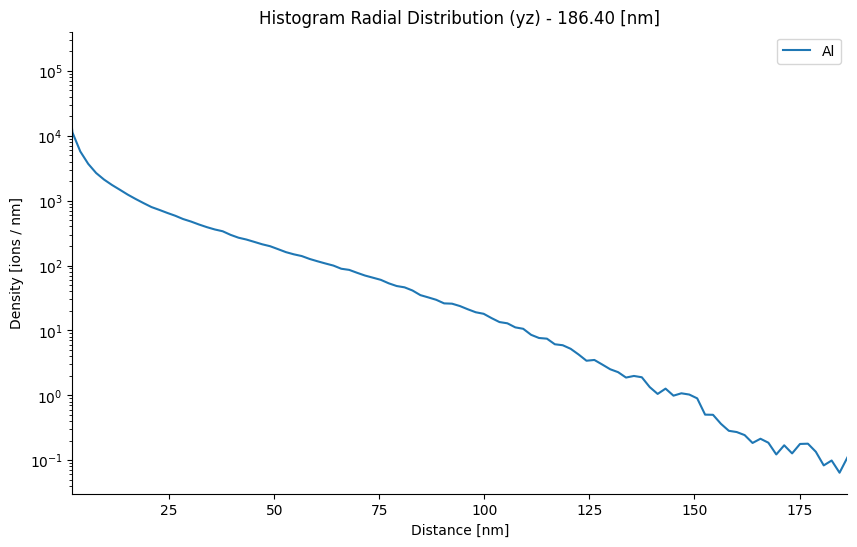

In [13]:
# Very small 100 nm (to more clearly show trend)
maximum = max(-min_radial, max_radial)

fig, ax = plt.subplots()
for i, ion in enumerate(sorted(data, key=sort_by_mass)):
    print(i, ion)
    radius = np.linalg.norm(data[ion]['collisions'][:, 1:], axis=1)
    plot_radial_distribution_hist(ax, radius, maximum, ion)
ax.set_title('Histogram Radial Distribution (yz) - %.2f [nm]' % maximum)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(2, maximum)
# ax.set_ylim(0, 60000)
ax.legend()
ax.set_xlabel('Distance [nm]')
ax.set_ylabel('Density [ions / nm]')
fig.set_size_inches(10, 6)
fig.savefig(os.path.join(IMAGE_DIRECTORY, 'sic-radial-hist.png'), transparent=False, dpi=300)

In [14]:
maximum = 100

for i, ion in enumerate(sorted(data, key=sort_by_mass)):
    print(i, ion)
    radius = np.linalg.norm(data[ion]['collisions'][:, 1:], axis=1)
    density, edges = np.histogram(radius, bins=1000, density=False, range=(1e-8, maximum))
    x = np.linspace(1e-8, maximum, len(density))
    with open(os.path.join(IMAGE_DIRECTORY, 'sic-collisions-%s.csv' % ion), 'w') as f:
        f.write('%s radial distance [nm], count [collisions/A^2]\n' % ion)
        for x,y in zip(x, density):
            f.write('{:3.2f},{}\n'.format(x, y))

0 Al
